In [1]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
sns.set()

In [2]:
url = "https://github.com/renatoquiliche/Insurance-Mathematics-Economics-ADR/blob/main/Databases/insurance.csv?raw=true"

data_insurance = pd.read_csv(url)

In [3]:
#Pre-processing for FAMD

categorical = pd.get_dummies(data_insurance[["sex","smoker"]]) 
numerical = data_insurance[["age","bmi","children", "charges"]]

scaler = RobustScaler()

#Escalamos la data numerica a la escala de la binaria
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical), columns=["age","bmi","children", "charges"])

#Unimos los dos tipos de data
final_data_scaled = pd.concat([numerical_data_scaled, categorical], axis=1)

In [4]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, early_exaggeration=13,
            init='pca', learning_rate='auto', method='barnes_hut', n_jobs=-1)
vecs_list_tsne = tsne.fit_transform(final_data_scaled)

print("Error", tsne.kl_divergence_)
#

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Error 0.5139656066894531


<AxesSubplot:>

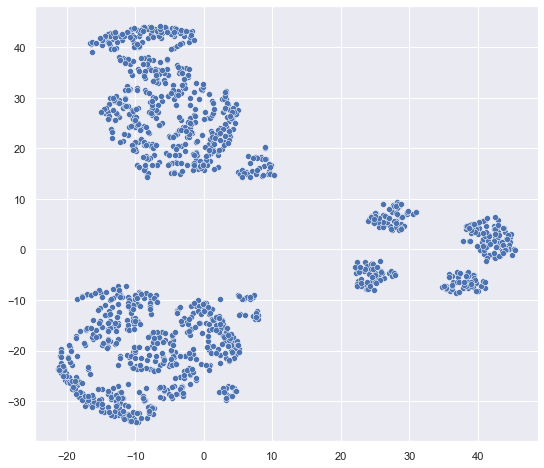

In [5]:
plt.figure(figsize=(9,8))
sns.scatterplot(x=vecs_list_tsne[:,0], y=vecs_list_tsne[:,1])

In [6]:
wcss = []
sil = []
db = []
components = pd.DataFrame(vecs_list_tsne, columns=['tsne1', 'tsne2'])

for i in range(2,20):
    kmeans = AgglomerativeClustering(n_clusters= i, linkage='single')
    kmeans.fit(components)
    #wcss.append(kmeans.inertia_)
    sil.append(silhouette_score(components, kmeans.labels_))
    db.append(davies_bouldin_score(components, kmeans.labels_))

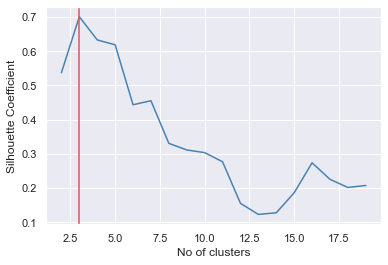

In [7]:
# SC Graph
plt.plot(range(2,20), sil, color="steelblue")
#plt.title('The Elbow Method')
plt.xlabel('No of clusters')
plt.ylabel('Silhouette Coefficient')
plt.axvline(3, color="indianred") # vertical
#plt.savefig(path_fig+"\Elbowmethod.png")
plt.show()

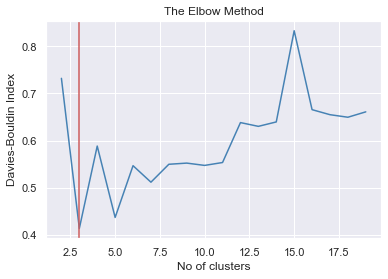

In [8]:
# DB Graph
plt.plot(range(2,20), db, color="steelblue")
plt.title('The Elbow Method')
plt.xlabel('No of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.axvline(3, color="indianred") # vertical
#plt.savefig(path_fig+"\Elbowmethod.png")
plt.show()

# Clustering visualization

In [9]:
# Cluster label estimation
from tkinter import font


kmeans4 = AgglomerativeClustering(n_clusters=4, linkage='single')
kmeans4.fit(components)

# Cluster label estimation
kmeans2 = AgglomerativeClustering(n_clusters=2, linkage='single')
kmeans2.fit(components)

# Cluster label estimation
kmeans9 = AgglomerativeClustering(n_clusters=4, linkage='single')
kmeans9.fit(components)

#data_insurance = pd.concat([data_insurance, components, pd.Series(kmeans.labels_, name="Cluster")], axis=1)


data_final = pd.concat([data_insurance, components
                        , pd.Series(kmeans4.labels_, name="HCluster4")
                        , pd.Series(kmeans2.labels_, name="HCluster2")
                        , pd.Series(kmeans9.labels_, name="HCluster9")], axis=1)

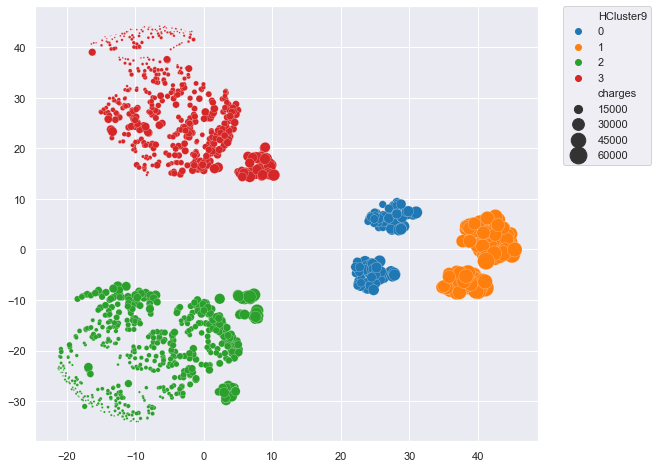

In [10]:
plt.figure(figsize=(9,8))
sns.scatterplot(x=vecs_list_tsne[:,0],y=vecs_list_tsne[:,1], sizes=(0, 300), 
                hue=data_final['HCluster9'], alpha=1, palette='tab10', size=data_insurance['charges'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Data analyitics supporting multiple insurance contracts based on categories

Text(0.5, 1.0, 'Categorical Clustering (smoker)')

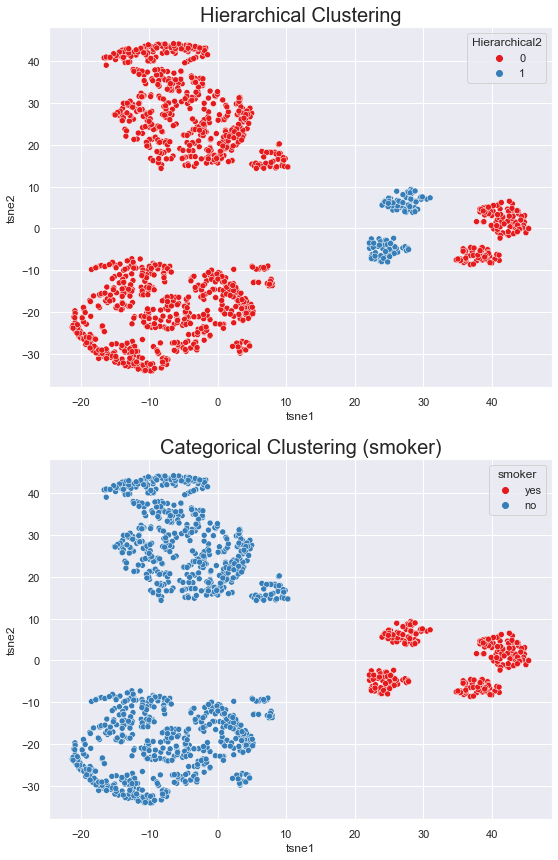

In [11]:
data_final["Hierarchical2"] = pd.get_dummies((data_final["HCluster9"]>0)).iloc[:,0]

fig, (ax1, ax2) = plt.subplots(2, 1)

fig.set_size_inches(9, 8)

plt.subplots_adjust(top=1.5)
sns.scatterplot(ax=ax1, data=data_final, x="tsne1", y="tsne2", hue=data_final["Hierarchical2"], palette="Set1")
ax1.set_title('Hierarchical Clustering', fontsize=20)

sns.scatterplot(ax=ax2, data=data_final, x="tsne1", y="tsne2", hue=data_final["smoker"], palette="Set1")
ax2.set_title('Categorical Clustering (smoker)', fontsize=20)

In [12]:
from sklearn.metrics.cluster import adjusted_rand_score

ARS = adjusted_rand_score(data_final["smoker"], data_final["Hierarchical2"])

print("Adjusted Rand-Score", f"{ARS:.2%}")

from sklearn.metrics import jaccard_score

JS = jaccard_score(pd.get_dummies(data_final["smoker"], drop_first=True), data_final["Hierarchical2"])

print("Jaccard Index", f"{JS:.2%}")

Adjusted Rand-Score 48.91%
Jaccard Index 45.99%


- The variable smoker defines natural clusters in the data (perfect Rand-score and Jaccard Index versus Hierarchical partition)
- The variable obesity generates a good partition into clusters when individuals smoke, proposed partition:
    - **Cluster 0:** Non-smoker
    - **Cluster 1:** Smoker + Non-obesity
    - **Cluster 2:** Smoker + Obesity

- The Non-smoker are the problem, they have non-linear complex patterns that divide them into natural clusters
- Another option: train a decision tree to make K-means clustering interpretable in terms of variables in original feature space

In [13]:
from sklearn.tree import DecisionTreeClassifier

DecisionTree = DecisionTreeClassifier(max_leaf_nodes=None, criterion="entropy", random_state=0)

data_insurance["HCluster9"] = data_final["HCluster9"]
categorical = pd.get_dummies(data_insurance[["sex","smoker"]], drop_first=True) 

x = pd.concat([numerical, categorical], axis=1)
y = data_insurance["HCluster9"]

DecisionTree.fit(x, y)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [14]:
import numpy as np
n_nodes = DecisionTree.tree_.node_count
children_left = DecisionTree.tree_.children_left
children_right = DecisionTree.tree_.children_right
feature = DecisionTree.tree_.feature
threshold = DecisionTree.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 13 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 4] <= 0.5 else to node 6.
	node=1 is a split node: go to node 2 if X[:, 5] <= 0.5 else to node 3.
		node=2 is a leaf node.
		node=3 is a split node: go to node 4 if X[:, 3] <= 33020.8681640625 else to node 5.
			node=4 is a leaf node.
			node=5 is a leaf node.
	node=6 is a split node: go to node 7 if X[:, 5] <= 0.5 else to node 8.
		node=7 is a leaf node.
		node=8 is a split node: go to node 9 if X[:, 3] <= 33131.63671875 else to node 12.
			node=9 is a split node: go to node 10 if X[:, 1] <= 30.125 else to node 11.
				node=10 is a leaf node.
				node=11 is a leaf node.
			node=12 is a leaf node.


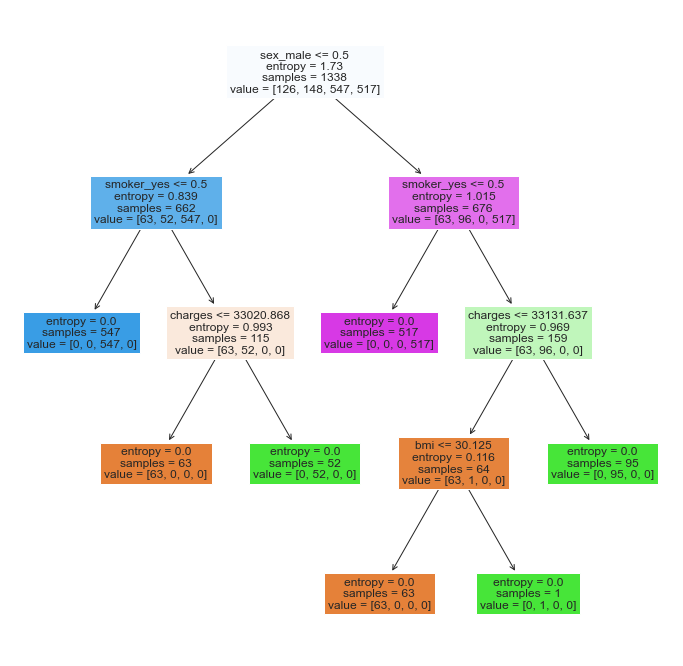

In [18]:
from sklearn import tree
plt.figure(figsize=(12,12))
tree.plot_tree(DecisionTree, filled=True, fontsize=12,
              feature_names=x.columns.values)
plt.show()

# ANOVA One-way

In [16]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('charges ~ C(Cluster_smoker_bmi)', data=input_simulation).fit()
sm.stats.anova_lm(model, typ=2)

NameError: name 'input_simulation' is not defined

In [ ]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=input_simulation, res_var='charges', xfac_var='FourContracts', anova_model='charges ~ C(FourContracts)')


display(res.tukey_summary)

print("(p-value < 0.05) rejects null hypothesis and indicates statistically significant differences")

In [ ]:
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print("Statistic SW: ", w)
print("P-value: ", round(pvalue))
print("The data is not drawn from normal distribution, H0 is rejected in Shapiro-Wilk test")

In [ ]:
input_simulation.to_csv('..\..\Databases\contracts.csv', index=False)